In [ ]:
! jt -t onedork -fs 18 -tfs 20 -dfs 15 -ofs 18 -cellw 1400

# Как не гонять гигабайты лишних данных в моделях машинного обучения

### Клепиков Константин

[https://t.me/KlepikovKonstantin](https://t.me/KlepikovKonstantin)

[https://github.com/KonstantinKlepikov](https://github.com/KonstantinKlepikov)

[konstantinklepikov.github.io](https://konstantinklepikov.github.io/)

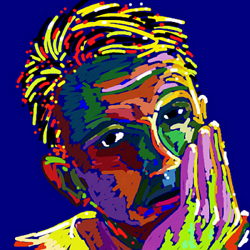

# С какими задачами можно столкнуться и зачем вообще питонисту работать с данными?

- Компания собирала дату, "потому что это важно"
- Люди, которые проектировали "склад" данных уволились, сошли с ума или умерли
- Пришло время "извлечь из этого смыслы" и "применить кейсы"

Это означает, что потребуется разобрать авгиевы конюшни данных и построить какие-то модели машинного обучения. И тут-то все как раз и вспоминают про Вас.

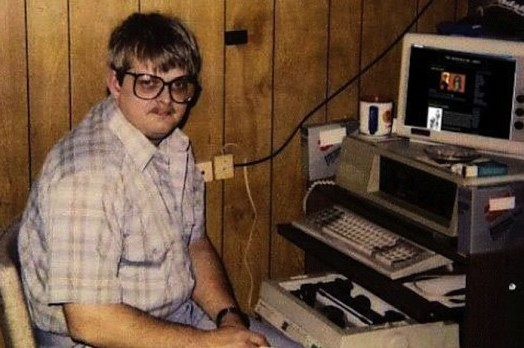

Но есть нюансы:

- Абсолютно никто не в курсе что значат все эти забавные числа и строки из базы данных
- Ни кого особо не интересует сколько это будет стоить в расчетах (кстати, как всегда, сделать надо было вчера)
- Совершенно очевидно, что на эту задачу амазоновские инстансы за 100500 миллиардов долларов Вам не выделят

# 1. Данные

In [1]:
#main
import numpy as np
import pandas as pd
import pandas_profiling
import json

# support
import corelib

# csv to pd loader
from corelib.data_loader import loader

# reduce memory usage for pd-index
from corelib.data_prep import reduce_mem_usage
from corelib.data_prep import reduce_obj_mem_usage

# searching for unical ordered values
from corelib.data_prep import search_func

# dump data with shell
from corelib.data_dump import dumper

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 100)

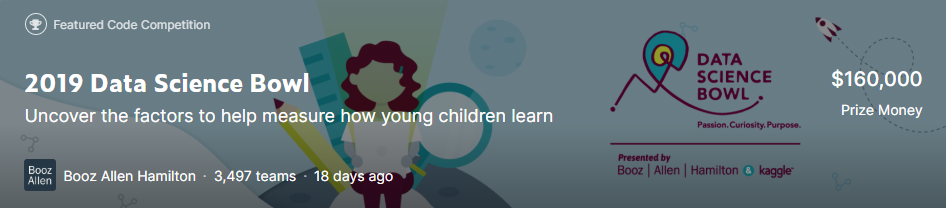

In this dataset, you are provided with game analytics for the PBS KIDS Measure Up! app. In this app, children navigate a map and complete various levels, which may be activities, video clips, games, or assessments. Each assessment is designed to test a child's comprehension of a certain set of measurement-related skills. There are five assessments: Bird Measurer, Cart Balancer, Cauldron Filler, Chest Sorter, and Mushroom Sorter.

[data-science-bowl-2019](https://www.kaggle.com/c/data-science-bowl-2019)

In [3]:
data = loader(mode='extract')
data.keys()

dict_keys(['train'])

In [4]:
df_train = data['train']
del data

### Memory usage

In [5]:
df_train.info(max_cols=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 11 entries, installation_id to world
dtypes: int64(3), object(8)
memory usage: 16.8+ MB


In [6]:
df_train.info(memory_usage='deep', max_cols=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 11 entries, installation_id to world
dtypes: int64(3), object(8)
memory usage: 147.3 MB


In [7]:
df_train.memory_usage(deep=True)

Index                   128
installation_id    13000000
event_id           13000000
game_session       14600000
timestamp          16200000
event_data         51761900
event_count         1600000
event_code          1600000
game_time           1600000
title              14984451
type               12625446
world              13474301
dtype: int64

**deep** bool, default False
If True, introspect the data deeply by interrogating object dtypes for system-level memory consumption, and include it in the returned values.

[* ссылка](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.memory_usage.html)

In [8]:
pandas_profiling.ProfileReport(df_train, minimal=True)

# 2. Что внутри?

## Почему вообще данные нужно приводить к какому-то виду?

- большинство алгоритмов ML требует предварительной подготовки данных
- часто данные нужно привести к определенному виду для того-чтобы срослась математика - например нормализовать или привести к логарифмическому масштабу
- машинное обучение точно плохо понимает неразобранные составные объекты

### К тому же имеется проблема вычислительной сложности

Для большинства алгоритмов сложность по пространству/времени в основном сосредоточена на построении модели. Это хорошо для продакшена, но сильно увеличивает расходы на поиск решения.

### Попробуем распаковать json

In [9]:
# json unpack
df_train_extracted = pd.io.json.json_normalize(
    df_train['event_data'].apply(json.loads))

**pandas.json_normalize**

Normalize semi-structured JSON data into a flat table

[* ссылка](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html)

**json.load**

Deserialize text file or binary file containing a JSON document to a Python object using.

`object_hook` is an optional function that will be called with the result of any object literal decoded (a dict). The return value of object_hook will be used instead of the dict. This feature can be used to implement custom decoders (e.g. JSON-RPC class hinting).

`object_pairs_hook` is an optional function that will be called with the result of any object literal decoded with an ordered list of pairs. The return value of object_pairs_hook will be used instead of the dict. This feature can be used to implement custom decoders. If object_hook is also defined, the object_pairs_hook takes priority.

[* ссылка](https://docs.python.org/3/library/json.html)

[** разъяснение по object_hook и object_pairs_hook](https://stackoverflow.com/questions/54519626/understanding-object-pairs-hook-in-json-loads)

* * *

**DataFrame.apply**

Apply a function along an axis of the DataFrame.

[* ссылка](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

### Что получили?

In [10]:
df_train_extracted.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 136 columns):
event_code                  int64
event_count                 int64
version                     object
game_time                   float64
description                 object
identifier                  object
media_type                  object
total_duration              float64
duration                    float64
coordinates.x               float64
coordinates.y               float64
coordinates.stage_width     float64
coordinates.stage_height    float64
castles_placed              object
molds                       object
size                        float64
sand                        float64
filled                      object
level                       float64
round                       float64
movie_id                    object
options                     object
animals                     object
round_target.size           float64
round_target.type           object
rou

In [11]:
df_train_extracted[['flower', 'flowers']].dropna().head(10)

,flower,flowers
2022,0.0,"[0, 0, 0, 0, 0]"
2026,0.0,"[0, 0, 0, 0, 8]"
2032,5.0,"[8, 8, 8, 7, 8]"
2034,5.0,"[8, 8, 8, 7, 0]"
2035,1.0,"[8, 8, 8, 7, 0]"
2036,1.0,"[0, 8, 8, 7, 0]"
2037,2.0,"[0, 8, 8, 7, 0]"
2038,2.0,"[0, 0, 8, 7, 0]"
2040,3.0,"[0, 0, 8, 7, 0]"
2041,3.0,"[0, 0, 0, 7, 0]"


In [12]:
df_train_extracted['shells'].dropna().head(10)

1128          [2, 3, 1]
1157       [2, 3, 2, 1]
1193    [2, 3, 2, 3, 2]
1245          [2, 3, 1]
1435          [2, 3, 1]
1459       [2, 3, 2, 1]
1484    [2, 3, 2, 1, 2]
3011          [2, 1, 2]
3042       [2, 1, 2, 1]
3070    [2, 1, 2, 1, 2]
Name: shells, dtype: object

In [13]:
df_train_extracted['bottles'].dropna().head(10)

3189    [{'color': 'blue', 'amount': 2}, {'color': 'blue', 'amount': 1}, {'color': 'purple', 'amount': 2...
3192    [{'color': 'blue', 'amount': 2}, {'color': 'blue', 'amount': 1}, {'color': 'purple', 'amount': 2...
3193    [{'color': 'blue', 'amount': 2}, {'color': 'blue', 'amount': 1}, {'color': 'purple', 'amount': 2...
3196    [{'color': 'blue', 'amount': 2}, {'color': 'blue', 'amount': 1}, {'color': 'purple', 'amount': 2...
3197    [{'color': 'blue', 'amount': 2}, {'color': 'blue', 'amount': 1}, {'color': 'purple', 'amount': 2...
3198    [{'color': 'blue', 'amount': 2}, {'color': 'blue', 'amount': 1}, {'color': 'purple', 'amount': 2...
3200    [{'color': 'blue', 'amount': 2}, {'color': 'blue', 'amount': 1}, {'color': 'purple', 'amount': 2...
3201    [{'color': 'blue', 'amount': 2}, {'color': 'blue', 'amount': 1}, {'color': 'purple', 'amount': 2...
3202    [{'color': 'blue', 'amount': 2}, {'color': 'blue', 'amount': 1}, {'color': 'purple', 'amount': 2...
3203    [{'color': 'blue', '

In [14]:
df_train_extracted['castles_placed'].dropna().head(10)

47                                                                                                      []
167                                                                                                     []
192              [{'size': 3, 'position': {'x': 567, 'y': 484, 'stage_width': 1015, 'stage_height': 762}}]
197    [{'size': 3, 'position': {'x': 567, 'y': 484, 'stage_width': 1015, 'stage_height': 762}}, {'size...
214    [{'size': 2, 'position': {'x': 568, 'y': 176, 'stage_width': 1015, 'stage_height': 762}}, {'size...
228    [{'size': 2, 'position': {'x': 568, 'y': 176, 'stage_width': 1015, 'stage_height': 762}}, {'size...
239    [{'size': 2, 'position': {'x': 773, 'y': 154, 'stage_width': 1015, 'stage_height': 762}}, {'size...
264    [{'size': 2, 'position': {'x': 773, 'y': 154, 'stage_width': 1015, 'stage_height': 762}}, {'size...
291                                                                                                     []
309              [{'size': 3, 'positi

In [15]:
df_train_extracted['description'].dropna().head(10)

3     Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The m...
4     Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The m...
18                                                          Drag the shovel to the molds to fill them up!
23                                                          Drag the shovel to the molds to fill them up!
30                                                                 When you're all done, tap this button.
32                                                                 When you're all done, tap this button.
41                                                          Drag the shovel to the molds to fill them up!
43                                                          Drag the shovel to the molds to fill them up!
48                                                          Drag the shovel to the molds to fill them up!
49                                            

In [16]:
df_train_extracted['filled'].dropna().head(10)

153    False
155    False
159     True
183     True
185    False
190     True
203    False
207    False
210     True
220    False
Name: filled, dtype: object

### В итоге

**Что еще можно встретить?**

- пустые множества, словари и списки
- 'NONE', 'nul', 'none', '0' и т.п.
- false и true
- 'False', 'True', 'Yes', 'No'
и т.д. - список сильно неполный

In [17]:
df_train_extracted.info(memory_usage='deep', max_cols=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 136 entries, event_code to chests
dtypes: float64(64), int64(2), object(70)
memory usage: 543.8 MB


In [18]:
df_train_extracted.memory_usage(deep=True)

Index                            128
event_code                   1600000
event_count                  1600000
version                      6466018
game_time                    1600000
description                 11735807
identifier                   9128648
media_type                   8634312
total_duration               1600000
duration                     1600000
coordinates.x                1600000
coordinates.y                1600000
coordinates.stage_width      1600000
coordinates.stage_height     1600000
castles_placed               6459048
molds                        6401440
size                         1600000
sand                         1600000
filled                       6406336
level                        1600000
round                        1600000
movie_id                     6442636
options                      6472784
animals                      6468368
round_target.size            1600000
round_target.type            6478669
round_target.animal          6479472
i

# 3. Борьба за память

На самом деле Pandas группирует и хранит "столбцы" блоками, разбитыми по типам. Иными словами float, int и objects хранятся раздельно, причем оптимизированно, без индексов. С числами все просто — столбцы в блоке объединяются в многомерный массив NumPy. При запросе значения происходит сопоставление индекса с массивом. С объектами немного сложнее. 

**Все это означает, что разные объекты по разному используют память.**

[* типы в pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#basics-dtypes)

In [19]:
numerics_part = df_train_extracted.select_dtypes(include=['number']).copy()
objects_part = df_train_extracted.select_dtypes(include=['object']).copy()
extravagant = df_train_extracted['flowers'].copy()

### Разберемся вначале с наименьшим злом - с числами

В Pandas используются подтипвы int8, int16, int32, int64, float16, float32, float64

In [20]:
numerics_part.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 66 columns):
event_code                  200000 non-null int64
event_count                 200000 non-null int64
game_time                   196724 non-null float64
total_duration              34617 non-null float64
duration                    67500 non-null float64
coordinates.x               100626 non-null float64
coordinates.y               100626 non-null float64
coordinates.stage_width     100626 non-null float64
coordinates.stage_height    100626 non-null float64
size                        13040 non-null float64
sand                        2057 non-null float64
level                       15021 non-null float64
round                       118206 non-null float64
round_target.size           2718 non-null float64
position                    6551 non-null float64
misses                      4469 non-null float64
shell_size                  2648 non-null float64
hole_position          

In [21]:
# reduce memory usage
numerics_part = reduce_mem_usage(numerics_part)

Mem. usage decreased to 26.32 Mb (73.9% reduction)


In [22]:
numerics_part.info(memory_usage='deep', max_cols=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 66 entries, event_code to dinosaur_count
dtypes: float16(61), float32(3), int16(2)
memory usage: 26.3 MB


#### Что тут происходит?

1. Мы получаем минимальное и максимальное значение в серии
2. Затем сравниваем с машинными лимитами для целочисленных типов numpy
3. Выбираем наименьшее

Вот как-то так:

```python
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] 
for col in df.columns:
    col_type = df[col].dtypes
    if col_type in numerics:
        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            # последовательно сравниваем от наименьшего инта начиная с np.int8
            # наверх и переопределяем тип для серии
        else:
            # последовательно сравниваем от наименьшего флота начиная с np.float16
            # наверх и переопределяем тип для серии                    
```

По сути мы выполнили такой самопальный вариант понижающего преобразования. На самом деле эта штука не совсем хорошо сделана и не решает, к примеру, такую историю

In [23]:
numerics_part['flower'].dropna().head(10)

2022    0.0
2026    0.0
2032    5.0
2034    5.0
2035    1.0
2036    1.0
2037    2.0
2038    2.0
2040    3.0
2041    3.0
Name: flower, dtype: float16

In [24]:
numerics_part.fillna(value=-1, inplace=True)

In [25]:
numerics_part = numerics_part.astype(int)

In [26]:
numerics_part = reduce_mem_usage(numerics_part)

Mem. usage decreased to 16.59 Mb (67.0% reduction)


In [27]:
numerics_part.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 66 columns):
event_code                  200000 non-null int16
event_count                 200000 non-null int16
game_time                   200000 non-null int32
total_duration              200000 non-null int32
duration                    200000 non-null int32
coordinates.x               200000 non-null int16
coordinates.y               200000 non-null int16
coordinates.stage_width     200000 non-null int16
coordinates.stage_height    200000 non-null int16
size                        200000 non-null int8
sand                        200000 non-null int8
level                       200000 non-null int8
round                       200000 non-null int8
round_target.size           200000 non-null int8
position                    200000 non-null int8
misses                      200000 non-null int8
shell_size                  200000 non-null int8
hole_position               200000 non-null int

In [28]:
# все в порядке?
numerics_part

,event_code,event_count,game_time,total_duration,duration,coordinates.x,coordinates.y,coordinates.stage_width,coordinates.stage_height,size,sand,level,round,round_target.size,position,misses,shell_size,hole_position,cloud_size,water_level,time_played,house.size,house.position,rocket,height,flower,session_duration,distance,target_size,group,buglength,stage_number,hat,bird_height,target_containers,containers,current_containers,total_containers,bottle.amount,tutorial_step,target_weight,weight,scale_weight,target_water_level,target_bucket,round_number,bucket,cauldron,layout.left.chickens,layout.right.chickens,table_weights,starting_weights,tape_length,bug_length,dwell_time,total_bowls,bowl_id,scale_weights,weights,nest,max_position,end_position,gate.row,gate.column,dinosaur_weight,dinosaur_count
0,2000,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2000,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2000,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,3010,2,53,6760,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,3110,3,6972,-1,6919,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,4070,4,9991,-1,-1,583,605,1015,762,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
6,4070,5,10622,-1,-1,601,570,1015,762,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,4070,6,11255,-1,-1,250,665,1015,762,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8,4070,7,11689,-1,-1,279,629,1015,762,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9,4070,8,12272,-1,-1,839,654,1015,762,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


### Объекты

Тип object в Pandas хранит строковое представление. Строки хранятся фрагментированно - значение в ячейке по сути является указателем. Как-то так:

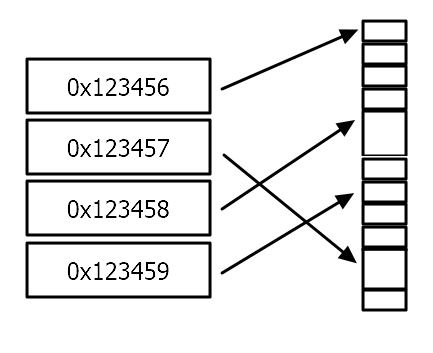

При этом резервируется много памяти и это для нас плохо. Желательно как можно быстрее всё что можно перегнать в числа

In [ ]:
# дропнуть то, что надо распаковывать

In [29]:
objects_part.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 70 columns):
version                2345 non-null object
description            69717 non-null object
identifier             68610 non-null object
media_type             68610 non-null object
castles_placed         999 non-null object
molds                  30 non-null object
filled                 2824 non-null object
movie_id               1107 non-null object
options                1395 non-null object
animals                1395 non-null object
round_target.type      2718 non-null object
round_target.animal    2718 non-null object
item_type              1811 non-null object
animal                 1811 non-null object
correct                13535 non-null object
holding_shell          2445 non-null object
has_water              2445 non-null object
shells                 247 non-null object
holes                  981 non-null object
cloud                  2616 non-null object
houses    

In [ ]:
# поменять на подтип categoty

In [ ]:
# отформатировать временную метку

In [ ]:
# сериализация - нюансы:
# нехешируемые объекты - их придется разбирать
# категории не получится сериализовать

In [ ]:
# конвеер - кодируем категории

# The End

[ссылка на этот ноут](https://github.com/KonstantinKlepikov/meetup-python-2020-02-13/blob/master/kernels/meetup_notebook.ipynb)

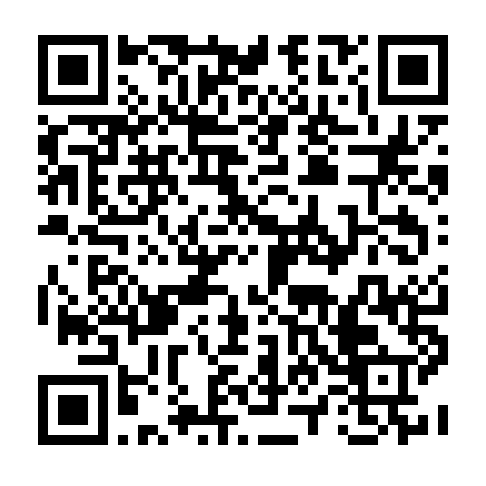
